In [7]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
zip_path = "/content/archive.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Zip açıldı")


Zip açıldı


In [8]:
BASE_DIR = "/content/NEU Metal Surface Defects Data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")


In [9]:
os.listdir(TRAIN_DIR)



['Scratches', 'Inclusion', 'Crazing', 'Patches', 'Rolled', 'Pitted']

In [10]:
def calculate_defect_score(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img = cv2.resize(img, (64, 64))
    score = np.std(img) / 255.0
    return score


In [11]:
def defect_scores(base_path):
    scores_dict = {}

    for cls in os.listdir(base_path):
        cls_path = os.path.join(base_path, cls)
        if not os.path.isdir(cls_path):
            continue

        scores = []
        for file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, file)
            score = calculate_defect_score(img_path)
            if score is not None:
                scores.append(score)

        scores_dict[cls] = scores

    return scores_dict


In [12]:
train_scores = defect_scores(TRAIN_DIR)


In [13]:
avg_scores = {}

for cls, scores in train_scores.items():
    if len(scores) > 0:
        avg_scores[cls] = np.mean(scores)

avg_scores


{'Scratches': np.float64(0.08129594155732003),
 'Inclusion': np.float64(0.051197837954413815),
 'Crazing': np.float64(0.1077936468248331),
 'Patches': np.float64(0.21023872473477948),
 'Rolled': np.float64(0.0593370162242948),
 'Pitted': np.float64(0.10325535475697532)}

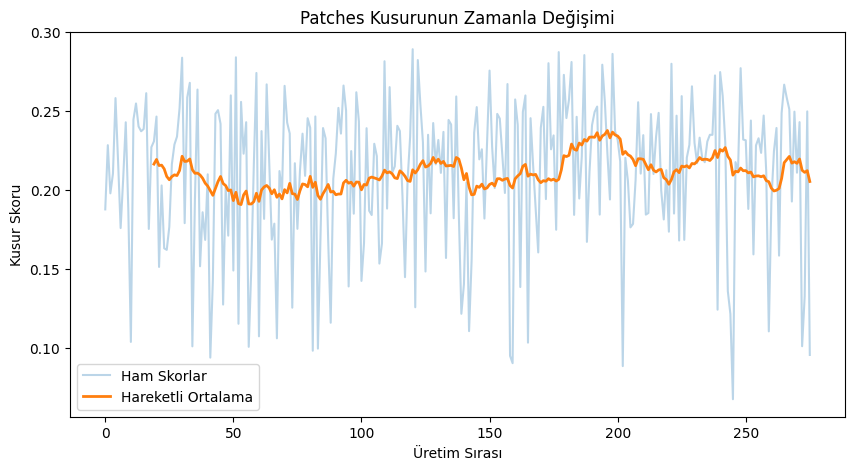

In [14]:
patches_scores = train_scores["Patches"]

window = 20
moving_avg = np.convolve(
    patches_scores,
    np.ones(window)/window,
    mode="valid"
)

plt.figure(figsize=(10,5))
plt.plot(patches_scores, alpha=0.3, label="Ham Skorlar")
plt.plot(
    range(window-1, window-1+len(moving_avg)),
    moving_avg,
    linewidth=2,
    label="Hareketli Ortalama"
)
plt.xlabel("Üretim Sırası")
plt.ylabel("Kusur Skoru")
plt.title("Patches Kusurunun Zamanla Değişimi")
plt.legend()
plt.show()


In [15]:
n = len(patches_scores)

first_part = patches_scores[:n//2]
last_part  = patches_scores[n//2:]

print("İlk yarı ortalama skor:", np.mean(first_part))
print("İkinci yarı ortalama skor:", np.mean(last_part))



İlk yarı ortalama skor: 0.20721882727569388
İkinci yarı ortalama skor: 0.2132586221938651


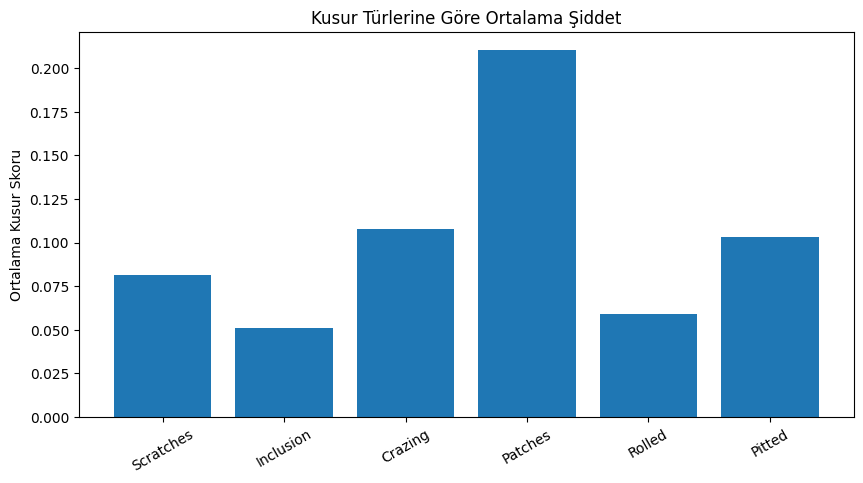

In [16]:
plt.figure(figsize=(10,5))
plt.bar(avg_scores.keys(), avg_scores.values())
plt.ylabel("Ortalama Kusur Skoru")
plt.title("Kusur Türlerine Göre Ortalama Şiddet")
plt.xticks(rotation=30)
plt.show()


In [17]:
import numpy as np

thresholds = {}

for cls, scores in train_scores.items():
    scores = np.array(scores)

    mean = np.mean(scores)
    std  = np.std(scores)

    threshold = mean + std
    thresholds[cls] = threshold

thresholds


{'Scratches': np.float64(0.11194637803597285),
 'Inclusion': np.float64(0.0734397590644971),
 'Crazing': np.float64(0.1276201507418992),
 'Patches': np.float64(0.2583752659594479),
 'Rolled': np.float64(0.07315875457159239),
 'Pitted': np.float64(0.13417871502886364)}

In [19]:
import os
import cv2
import numpy as np
BASE_DIR = "/content/NEU Metal Surface Defects Data"

train_dir = os.path.join(BASE_DIR, "train")
test_dir  = os.path.join(BASE_DIR, "test")
test_scores = {}

for cls in os.listdir(test_dir):
    cls_path = os.path.join(test_dir, cls)

    if not os.path.isdir(cls_path):
        continue

    scores = []

    for file in sorted(os.listdir(cls_path)):
        img_path = os.path.join(cls_path, file)

        if not img_path.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        score = calculate_defect_score(img_path)
        scores.append(score)

    test_scores[cls] = scores

test_scores.keys()
critical_counts = {}

for cls, scores in test_scores.items():
    scores = np.array(scores)
    critical = scores > thresholds[cls]
    critical_counts[cls] = np.sum(critical)

critical_counts




{'Scratches': np.int64(0),
 'Inclusion': np.int64(0),
 'Crazing': np.int64(0),
 'Patches': np.int64(0),
 'Rolled': np.int64(0),
 'Pitted': np.int64(0)}

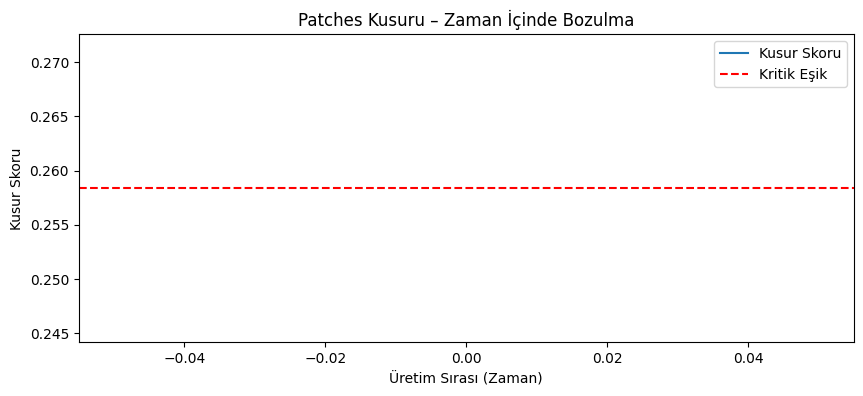

In [20]:
patches = np.array(test_scores["Patches"])

plt.figure(figsize=(10,4))
plt.plot(patches, label="Kusur Skoru")

plt.axhline(
    y=thresholds["Patches"],
    color="red",
    linestyle="--",
    label="Kritik Eşik"
)

plt.xlabel("Üretim Sırası (Zaman)")
plt.ylabel("Kusur Skoru")
plt.title("Patches Kusuru – Zaman İçinde Bozulma")
plt.legend()
plt.show()


In [21]:
len(patches_scores), patches_scores[:10]


(276,
 [np.float64(0.18770013382914713),
  np.float64(0.22842751033803269),
  np.float64(0.1978864216983804),
  np.float64(0.21032692617222273),
  np.float64(0.25828214392739157),
  np.float64(0.21825074832881305),
  np.float64(0.17587554227250346),
  np.float64(0.20715744079492981),
  np.float64(0.242943226802026),
  np.float64(0.1875174294084919)])

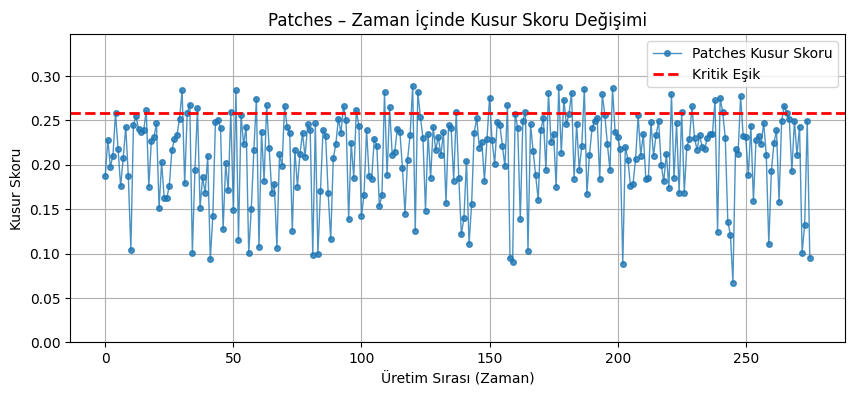

In [22]:
patches = np.array(patches_scores)

plt.figure(figsize=(10,4))

plt.plot(
    patches,
    marker='o',
    linestyle='-',
    markersize=4,
    linewidth=1,
    alpha=0.8,
    label="Patches Kusur Skoru"
)

plt.axhline(
    y=thresholds["Patches"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Kritik Eşik"
)

# 🔥 EN KRİTİK SATIRLAR
plt.ylim(0, max(patches) * 1.2)

plt.xlabel("Üretim Sırası (Zaman)")
plt.ylabel("Kusur Skoru")
plt.title("Patches – Zaman İçinde Kusur Skoru Değişimi")
plt.legend()
plt.grid(True)
plt.show()

